# Checkpoint 1: Citation-Semantic Misalignment in Academic Networks
## CSCE 670 — Data Mining Project

**Theme:** Investigating the structural divergence between citation graphs and topic-semantic graphs in academic literature. Papers cite each other for many reasons beyond topical similarity — prestige, recency, self-citation, and community effects. Understanding this misalignment can improve paper classification, recommendation, and anomaly detection.

**Research Direction:** Build both a citation graph and a topic-semantic graph from the same set of papers, then analyze where they agree, where they diverge, and whether that divergence is structured and meaningful.

In [1]:
!pip install torch torch-geometric ogb scikit-learn networkx matplotlib seaborn pandas numpy gensim python-louvain scipy wordcloud -q
print("All packages installed.")

All packages installed.


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter, defaultdict
from scipy import stats, sparse
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

# Plotting config
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')
SEED = 42
np.random.seed(SEED)
print("Imports complete.")

Imports complete.


---
## Section A: Identification of Candidate Datasets

We evaluate three candidate datasets for this project. For each, we provide the required information: name/source, course topic alignment, potential beyond-course techniques, size/structure, data types, target variable(s), and licensing.

### Dataset 1: ogbn-arxiv (Open Graph Benchmark)
- **Source:** Stanford OGB (https://ogb.stanford.edu/docs/nodeprop/#ogbn-arxiv), raw text from TAPE repo (https://github.com/XiaoxinHe/TAPE)
- **Course alignment:** Graph mining (PageRank, community detection), text mining (topic modeling, TF-IDF), clustering
- **Beyond-course:** GNNs for node classification, transformer-based text embeddings, contrastive multi-view learning
- **Size:** 169,343 nodes (papers), 1,166,243 directed citation edges
- **Data types:** Paper titles + abstracts (text), 128-dim word2vec features, publication year (2005–2020), arXiv category labels
- **Target:** 40-class arXiv subject area classification
- **License:** ODC-BY (Open Data Commons Attribution License)

### Dataset 2: DBLP (HGB — Heterogeneous Graph Benchmark)
- **Source:** HGB benchmark (https://github.com/THUDM/HGB)
- **Course alignment:** Graph mining (heterogeneous graphs, PageRank), community detection across node types
- **Beyond-course:** Heterogeneous GNNs (HAN, HGT), metapath-based analysis
- **Size:** ~26,128 papers, ~4,057 authors, ~20 venues, ~7,723 terms; multiple edge types
- **Data types:** Paper features (bag-of-words), author–paper edges, paper–venue edges, paper–term edges
- **Target:** 4-class paper topic classification (Database, Data Mining, AI, Information Retrieval)
- **License:** Open for research use

### Dataset 3: Cora (Full version with raw text)
- **Source:** PyG built-in / Planetoid (https://github.com/kimiyoung/planetoid), full version via torch_geometric.datasets
- **Course alignment:** Graph mining, text mining, clustering
- **Beyond-course:** GNNs, few-shot node classification
- **Size:** ~19,793 nodes, ~126,842 edges (full version); or 2,708 nodes, 5,429 edges (standard)
- **Data types:** Paper bag-of-words features (1,433 dims), citation edges
- **Target:** 7-class (standard) or 70-class (full) topic classification
- **License:** Open for research use

In [3]:
# --- Load all three candidate datasets ---

import os
import urllib.request
import gzip
import csv
import shutil
import torch

# Fix for PyTorch 2.6+: OGB uses torch.load without weights_only=False,
# which fails under the new default. We patch it before importing OGB.
_original_torch_load = torch.load
def _patched_torch_load(*args, **kwargs):
    kwargs.setdefault('weights_only', False)
    return _original_torch_load(*args, **kwargs)
torch.load = _patched_torch_load

# Clear corrupted processed cache (if previous run failed mid-save)
for cache_dir in ['./data/ogbn_arxiv/processed', './data/arxiv/processed']:
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)
        print(f"Cleared stale cache: {cache_dir}")

# ---- Dataset 1: ogbn-arxiv ----
from ogb.nodeproppred import PygNodePropPredDataset

dataset_arxiv = PygNodePropPredDataset(name='ogbn-arxiv', root='./data/')
data_arxiv = dataset_arxiv[0]

# Restore original torch.load
torch.load = _original_torch_load

# Download raw text (titles + abstracts) from Stanford SNAP
TEXT_URL = "https://snap.stanford.edu/ogb/data/misc/ogbn_arxiv/titleabs.tsv.gz"
text_file_path = './data/ogbn_arxiv/titleabs.tsv.gz'

if not os.path.exists(text_file_path):
    os.makedirs('./data/ogbn_arxiv/', exist_ok=True)
    print("Downloading raw text from Stanford SNAP (~67 MB)...")
    try:
        urllib.request.urlretrieve(TEXT_URL, text_file_path)
        print("Download complete.")
    except Exception as e:
        print(f"Download failed: {e}")
        print("Will proceed using OGB built-in features as fallback.")

# Build paperid -> node_idx mapping from OGB metadata
mapping_path = './data/ogbn_arxiv/mapping/nodeidx2paperid.csv.gz'
paperid_to_nodeidx = {}
with gzip.open(mapping_path, 'rt') as f:
    reader = csv.reader(f)
    next(reader)  # skip header
    for row in reader:
        node_idx, paper_id = int(row[0]), int(row[1])
        paperid_to_nodeidx[paper_id] = node_idx

print(f"Loaded {len(paperid_to_nodeidx):,} paper ID -> node index mappings.")

# Parse the text file: each line is "paper_id\ttitle\tabstract"
texts_arxiv = {}
if os.path.exists(text_file_path):
    with gzip.open(text_file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) < 2:
                continue
            try:
                paper_id = int(parts[0])
            except ValueError:
                continue  # skip header or malformed lines
            title = parts[1] if len(parts) > 1 else ""
            abstract = parts[2] if len(parts) > 2 else ""
            # Map paper_id to node index
            if paper_id in paperid_to_nodeidx:
                node_id = paperid_to_nodeidx[paper_id]
                texts_arxiv[node_id] = {'title': title, 'abstract': abstract}

    print(f"Loaded text for {len(texts_arxiv):,} papers (mapped to node indices).")
    sample_keys = sorted(list(texts_arxiv.keys()))[:5]
    print(f"  Key range: {min(texts_arxiv.keys())} .. {max(texts_arxiv.keys())} (graph has {data_arxiv.num_nodes} nodes)")
    print(f"  Sample title: {texts_arxiv[sample_keys[0]]['title'][:80]}")
else:
    print("WARNING: Raw text not available. Topic modeling will use OGB word2vec features.")

# ---- Dataset 3: Cora ----
from torch_geometric.datasets import Planetoid, CoraFull

dataset_cora = Planetoid(root='./data/', name='Cora')
data_cora = dataset_cora[0]

dataset_cora_full = CoraFull(root='./data/')
data_cora_full = dataset_cora_full[0]

print("\nAll datasets loaded successfully.")

Cleared stale cache: ./data/ogbn_arxiv/processed


Processing...


Loading necessary files...
This might take a while.


Processing graphs...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 10180.35it/s]

Converting graphs into PyG objects...



  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 1274.09it/s]

Saving...


Done!


Loaded 169,343 paper ID -> node index mappings.


Loaded text for 169,343 papers (mapped to node indices).
  Key range: 0 .. 169342 (graph has 169343 nodes)
  Sample title: evasion attacks against machine learning at test time



All datasets loaded successfully.


In [4]:
# --- Quick summary statistics for all three candidate datasets ---

import torch

def compute_avg_degree(edge_index, num_nodes):
    """Average degree from an edge_index tensor."""
    return edge_index.shape[1] / num_nodes

summary = pd.DataFrame({
    'Dataset': ['ogbn-arxiv', 'Cora (standard)', 'Cora-Full'],
    'Nodes': [
        data_arxiv.num_nodes,
        data_cora.num_nodes,
        data_cora_full.num_nodes
    ],
    'Edges': [
        data_arxiv.num_edges,
        data_cora.num_edges,
        data_cora_full.num_edges
    ],
    'Classes': [
        len(torch.unique(data_arxiv.y)),
        len(torch.unique(data_cora.y)),
        len(torch.unique(data_cora_full.y))
    ],
    'Has Raw Text': [len(texts_arxiv) > 0, False, False],
    'Has Temporal': [True, False, False],
    'Avg Degree': [
        f"{compute_avg_degree(data_arxiv.edge_index, data_arxiv.num_nodes):.1f}",
        f"{compute_avg_degree(data_cora.edge_index, data_cora.num_nodes):.1f}",
        f"{compute_avg_degree(data_cora_full.edge_index, data_cora_full.num_nodes):.1f}"
    ]
})

# DBLP is described from documentation (HGB download is non-trivial)
dblp_row = pd.DataFrame([{
    'Dataset': 'DBLP (HGB)',
    'Nodes': '~26,128 papers',
    'Edges': '~239,566',
    'Classes': 4,
    'Has Raw Text': False,
    'Has Temporal': False,
    'Avg Degree': '~18.3'
}])
summary = pd.concat([summary.iloc[:1], dblp_row, summary.iloc[1:]], ignore_index=True)

print("=== Candidate Dataset Summary ===")
display(summary)

=== Candidate Dataset Summary ===


,Dataset,Nodes,Edges,Classes,Has Raw Text,Has Temporal,Avg Degree
0,ogbn-arxiv,169343,1166243,40,True,True,6.9
1,DBLP (HGB),"~26,128 papers","~239,566",4,False,False,~18.3
2,Cora (standard),2708,10556,7,False,False,3.9
3,Cora-Full,19793,126842,70,False,False,6.4


---
## Section B: Comparative Analysis

The table below compares all three candidate datasets across six dimensions required by the assignment: supported data mining tasks (course and beyond-course), data quality issues, algorithmic feasibility, bias considerations, and ethical considerations.

In [5]:
# --- Structured comparison table across all required dimensions ---

comparison = pd.DataFrame({
    'Dimension': [
        'Course Techniques',
        'Beyond-Course Techniques',
        'Data Quality Issues',
        'Algorithmic Feasibility',
        'Bias Considerations',
        'Ethical Considerations'
    ],
    'ogbn-arxiv': [
        'PageRank, community detection, topic modeling (LDA), TF-IDF, clustering',
        'GNNs, transformer embeddings, multi-view graph learning, contrastive learning',
        'Some abstracts missing/short; citation edges only in one temporal direction; class imbalance across 40 categories',
        'Manageable on single GPU; 169K nodes fits in memory; Louvain/Leiden scale well; LDA on 169K docs feasible',
        'CS-only papers; English-only; arXiv submission bias (top institutions overrepresented); temporal bias toward recent papers',
        'Public metadata only; no individual harm; but analysis of citation manipulation could affect reputations if applied to real identities'
    ],
    'DBLP (HGB)': [
        'Heterogeneous graph mining, PageRank, community detection, clustering',
        'Heterogeneous GNNs (HAN, HGT), metapath-based mining',
        'Smaller scale limits statistical power; bag-of-words only (no raw text); only 4 coarse classes',
        'Very manageable (26K nodes); but heterogeneous methods add implementation complexity',
        'Venue selection bias (only top DB/DM/AI/IR venues); author disambiguation issues in DBLP',
        'Similar to ogbn-arxiv; low risk'
    ],
    'Cora / Cora-Full': [
        'Graph mining, PageRank, community detection, text clustering',
        'GNNs, few-shot classification',
        'Small and sparse; bag-of-words features lose semantic meaning; standard version heavily preprocessed',
        'Trivially manageable; but too small for meaningful topic modeling or community analysis',
        'Very narrow CS subfield; heavily curated; not representative of broader academic citation patterns',
        'Low risk; well-established benchmark'
    ]
})

styled = comparison.set_index('Dimension').style.set_properties(
    **{'text-align': 'left', 'white-space': 'pre-wrap'}
)
display(styled)

,ogbn-arxiv,DBLP (HGB),Cora / Cora-Full
Dimension,,,
Course Techniques,"PageRank, community detection, topic modeling (LDA), TF-IDF, clustering","Heterogeneous graph mining, PageRank, community detection, clustering","Graph mining, PageRank, community detection, text clustering"
Beyond-Course Techniques,"GNNs, transformer embeddings, multi-view graph learning, contrastive learning","Heterogeneous GNNs (HAN, HGT), metapath-based mining","GNNs, few-shot classification"
Data Quality Issues,Some abstracts missing/short; citation edges only in one temporal direction; class imbalance across 40 categories,Smaller scale limits statistical power; bag-of-words only (no raw text); only 4 coarse classes,Small and sparse; bag-of-words features lose semantic meaning; standard version heavily preprocessed
Algorithmic Feasibility,Manageable on single GPU; 169K nodes fits in memory; Louvain/Leiden scale well; LDA on 169K docs feasible,Very manageable (26K nodes); but heterogeneous methods add implementation complexity,Trivially manageable; but too small for meaningful topic modeling or community analysis
Bias Considerations,CS-only papers; English-only; arXiv submission bias (top institutions overrepresented); temporal bias toward recent papers,Venue selection bias (only top DB/DM/AI/IR venues); author disambiguation issues in DBLP,Very narrow CS subfield; heavily curated; not representative of broader academic citation patterns
Ethical Considerations,Public metadata only; no individual harm; but analysis of citation manipulation could affect reputations if applied to real identities,Similar to ogbn-arxiv; low risk,Low risk; well-established benchmark


### Discussion

The three datasets offer very different trade-offs for studying citation-semantic misalignment. **Cora/Cora-Full**, while a beloved benchmark, is simply too small and preprocessed for our purposes: its 2,708 nodes (standard) cannot support meaningful community detection, and its bag-of-words features strip away the semantic richness needed for topic modeling. Cora-Full is larger (~19K nodes) but still lacks raw text and temporal metadata.

**DBLP (HGB)** offers an interesting heterogeneous structure with author and venue information, but its four coarse-grained classes and lack of raw text severely limit the depth of topic-semantic analysis. Its heterogeneous nature adds implementation complexity without directly serving our core research question about citation vs. topic alignment.

**ogbn-arxiv** is clearly the best fit: it provides the largest citation network (169,343 papers, 1,166,243 edges) with raw text (titles and abstracts available for all 169K papers via the Stanford SNAP mirror), fine-grained labels (40 arXiv CS subcategories), and temporal metadata spanning 1971-2020. This combination uniquely enables us to build and compare both citation-structural and topic-semantic views of the same paper collection, which is the heart of our research question. It is also the standard benchmark for text-attributed graph methods (TAPE, P2TAG, SimTeG), making our results directly comparable to recent work. Additionally, the dataset is remarkably clean — as we confirm in the EDA, it has zero missing text entries, zero duplicate edges, zero self-loops, and forms a single connected component, letting us focus on the research question rather than data wrangling.

---
## Section C: Dataset Selection

**Selected dataset: ogbn-arxiv**

**Reasons:**
- Largest citation network with raw text available (titles + abstracts for all 169K papers)
- Temporal metadata (2005–2020) enables analysis of whether citation-semantic misalignment changes over time
- 40 fine-grained arXiv categories provide ground truth for validating both citation communities and topic clusters
- Standard TAG benchmark — directly comparable to all recent work (TAPE, P2TAG, GAugLLM, SimTeG)
- Supports all required course techniques: PageRank, community detection, topic modeling, clustering
- Rich enough for beyond-course techniques: GNNs, multi-view learning, transformer embeddings

**Trade-offs acknowledged:**
- CS papers only — findings may not generalize to other disciplines
- No author metadata in the standard dataset (would need external linking)
- Citation edges are directed and temporal — papers can only cite older papers
- Abstracts vary in quality and length

---
## Section D: Exploratory Data Analysis

We analyze the selected dataset from three complementary perspectives:

1. **Citation graph structure** — the "how papers connect" view. We examine degree distributions, PageRank, and community structure using course techniques.
2. **Text/topic structure** — the "what papers discuss" view. We apply TF-IDF and LDA topic modeling to discover latent topics from paper abstracts.
3. **The misalignment between them** — the core research question. We quantify where citation communities and topic clusters agree and diverge, and whether that divergence is structured and meaningful.

This three-pronged approach lets us establish the existence and character of citation-semantic misalignment before committing to a specific modeling strategy.

### Part D.1: Basic Dataset Statistics

Before any analysis, we inspect the data for quality issues: missing text, duplicates, self-loops, isolated nodes, class imbalance, and temporal distribution. Each issue is documented with an explanation of how we handle it.

In [6]:
# --- Convert data to numpy arrays for efficient manipulation ---

edge_index = data_arxiv.edge_index.numpy()  # shape: [2, num_edges]
node_years = data_arxiv.node_year.numpy().flatten()
labels = data_arxiv.y.numpy().flatten()
num_nodes = data_arxiv.num_nodes
num_edges = data_arxiv.num_edges

print(f"Nodes:       {num_nodes:,}")
print(f"Edges:       {num_edges:,}")
print(f"Classes:     {len(np.unique(labels))}")
print(f"Year range:  {node_years.min()} \u2013 {node_years.max()}")
print(f"Feature dim: {data_arxiv.x.shape[1]}")
print(f"Papers with text: {len(texts_arxiv):,}")

Nodes:       169,343
Edges:       1,166,243
Classes:     40
Year range:  1971 – 2020
Feature dim: 128
Papers with text: 169,343


In [7]:
# --- Data quality audit ---
# WHY: Real-world datasets have imperfections. We must identify and handle
# them explicitly rather than letting them silently corrupt our analysis.

print("=== Data Quality Audit ===")

# 1. Missing text
missing_text = num_nodes - len(texts_arxiv)
print(f"\n1. Missing text: {missing_text:,} papers ({missing_text/num_nodes*100:.2f}%)")
if missing_text > 0:
    print("   -> These papers will be excluded from topic modeling but retained in the citation graph.")
elif missing_text < 0:
    print(f"   -> Text dict has more entries than graph nodes; extra keys will be ignored.")

# 2. Short abstracts
short_threshold = 20
short_abstracts = sum(
    1 for nid in texts_arxiv
    if len(texts_arxiv[nid]['abstract'].split()) < short_threshold
)
n_with_text = max(len(texts_arxiv), 1)
print(f"\n2. Short abstracts (<{short_threshold} words): {short_abstracts:,} ({short_abstracts/n_with_text*100:.2f}%)")
print("   -> Retained but flagged as potential noise for topic modeling.")

# 3. Duplicate edges
edge_set = set(zip(edge_index[0], edge_index[1]))
n_unique_edges = len(edge_set)
n_duplicate_edges = num_edges - n_unique_edges
print(f"\n3. Duplicate edges: {n_duplicate_edges:,}")
if n_duplicate_edges > 0:
    print("   -> Will use de-duplicated edge set for analysis.")
else:
    print("   -> None found. Edge set is clean.")

# 4. Self-loops
self_loops = np.sum(edge_index[0] == edge_index[1])
print(f"\n4. Self-loops: {self_loops:,}")
if self_loops > 0:
    print("   -> Will remove self-loops before building the graph.")
else:
    print("   -> None found.")

# 5. Isolated nodes
nodes_with_edges = set(edge_index[0]) | set(edge_index[1])
isolated_nodes = num_nodes - len(nodes_with_edges)
print(f"\n5. Isolated nodes (no edges): {isolated_nodes:,} ({isolated_nodes/num_nodes*100:.2f}%)")
if isolated_nodes > 0:
    print("   -> Isolated nodes cannot participate in citation-based analysis but are included in topic modeling.")
else:
    print("   -> All nodes participate in the citation graph.")

# 6. Class imbalance
label_counts = pd.Series(labels).value_counts()
imbalance_ratio = label_counts.max() / label_counts.min()
print(f"\n6. Class imbalance ratio (largest/smallest): {imbalance_ratio:.1f}x")
print(f"   Largest class: {label_counts.max():,} papers")
print(f"   Smallest class: {label_counts.min():,} papers")
print("   -> Significant imbalance. Will note this when interpreting community-label alignment.")

=== Data Quality Audit ===

1. Missing text: 0 papers (0.00%)



2. Short abstracts (<20 words): 190 (0.11%)
   -> Retained but flagged as potential noise for topic modeling.

3. Duplicate edges: 0
   -> None found. Edge set is clean.

4. Self-loops: 0
   -> None found.



5. Isolated nodes (no edges): 0 (0.00%)
   -> All nodes participate in the citation graph.

6. Class imbalance ratio (largest/smallest): 942.1x
   Largest class: 27,321 papers
   Smallest class: 29 papers
   -> Significant imbalance. Will note this when interpreting community-label alignment.


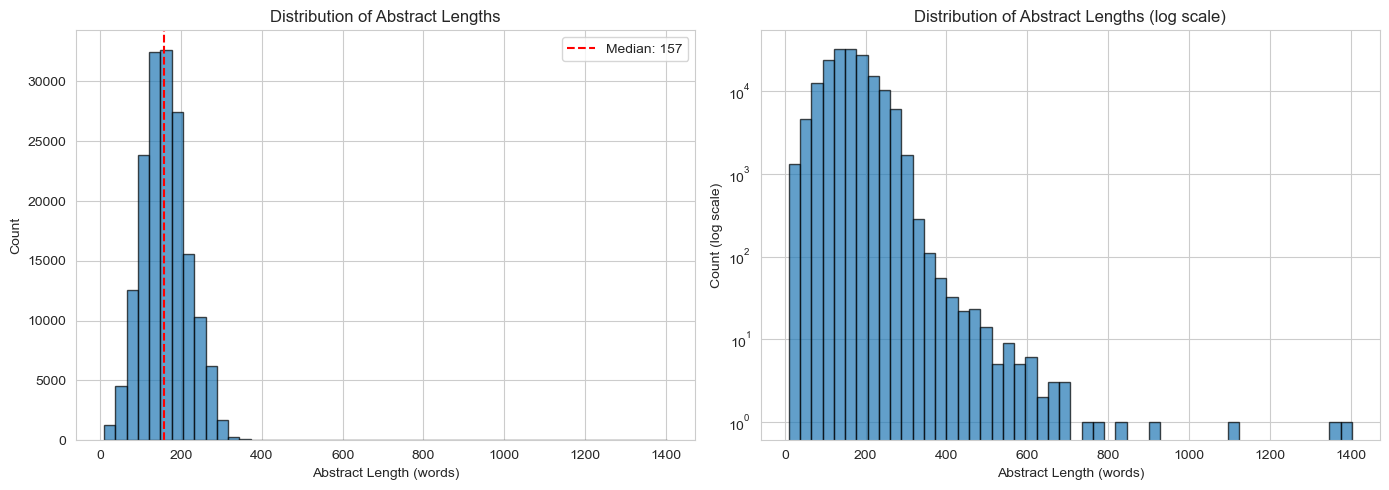

Mean abstract length: 161 words
Median abstract length: 157 words
Papers with abstracts < 20 words: 190 (0.11%)


In [8]:
# --- Abstract length distribution ---
# WHY: Understanding the distribution of document lengths helps us set
# appropriate thresholds for text filtering and anticipate noise sources.

abstract_lengths = [
    len(texts_arxiv[nid]['abstract'].split())
    for nid in texts_arxiv
]

if len(abstract_lengths) == 0:
    print("ERROR: No abstracts loaded. Check the TAPE text file parsing above.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(abstract_lengths, bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Abstract Length (words)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribution of Abstract Lengths')
    axes[0].axvline(np.median(abstract_lengths), color='red', linestyle='--',
                    label=f'Median: {np.median(abstract_lengths):.0f}')
    axes[0].legend()

    axes[1].hist(abstract_lengths, bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Abstract Length (words)')
    axes[1].set_ylabel('Count (log scale)')
    axes[1].set_title('Distribution of Abstract Lengths (log scale)')

    plt.tight_layout()
    plt.show()

    print(f"Mean abstract length: {np.mean(abstract_lengths):.0f} words")
    print(f"Median abstract length: {np.median(abstract_lengths):.0f} words")
    print(f"Papers with abstracts < {short_threshold} words: {short_abstracts} ({short_abstracts/len(abstract_lengths)*100:.2f}%)")

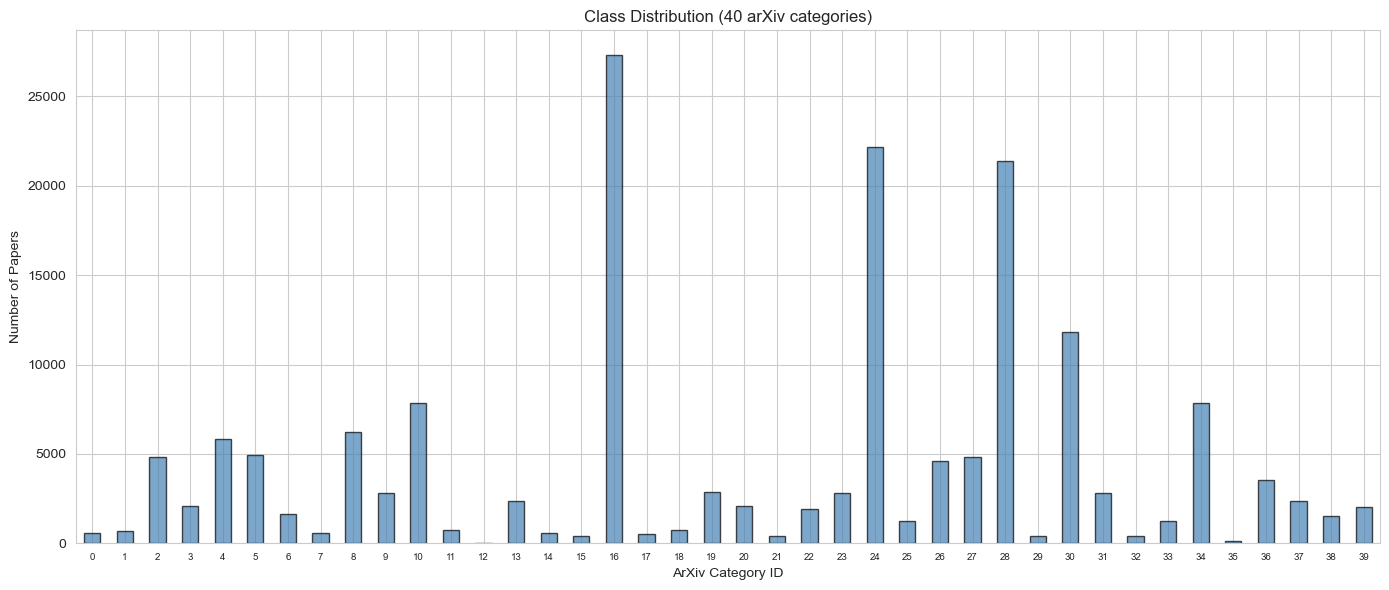

Largest class:  27,321 papers (category 16)
Smallest class: 29 papers (category 12)
Imbalance ratio: 942.1x


In [9]:
# --- Label distribution ---
# WHY: Understanding class balance informs how we interpret community
# detection and topic modeling results. Highly imbalanced classes may
# dominate both citation communities and LDA topics.

label_counts_sorted = pd.Series(labels).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
label_counts_sorted.plot(kind='bar', ax=ax, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('ArXiv Category ID')
ax.set_ylabel('Number of Papers')
ax.set_title('Class Distribution (40 arXiv categories)')
ax.tick_params(axis='x', rotation=0, labelsize=7)
plt.tight_layout()
plt.show()

print(f"Largest class:  {label_counts_sorted.max():,} papers (category {label_counts_sorted.idxmax()})")
print(f"Smallest class: {label_counts_sorted.min():,} papers (category {label_counts_sorted.idxmin()})")
print(f"Imbalance ratio: {label_counts_sorted.max() / label_counts_sorted.min():.1f}x")

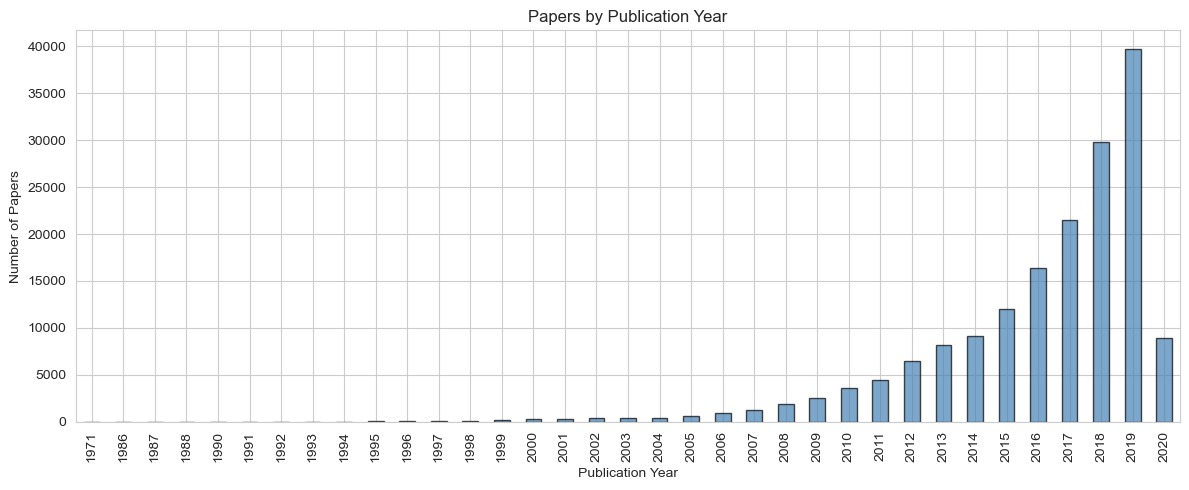

Year range: 1971 – 2020
Most papers in: 2019 (39,711 papers)


In [10]:
# --- Temporal distribution ---
# WHY: The dataset spans 2005-2020. Understanding the temporal distribution
# is critical because (a) citation edges are strictly temporal (a paper can
# only cite older papers), and (b) we want to study how misalignment
# evolves over time.

year_counts = pd.Series(node_years).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 5))
year_counts.plot(kind='bar', ax=ax, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Publication Year')
ax.set_ylabel('Number of Papers')
ax.set_title('Papers by Publication Year')
plt.tight_layout()
plt.show()

print(f"Year range: {node_years.min()} \u2013 {node_years.max()}")
print(f"Most papers in: {year_counts.idxmax()} ({year_counts.max():,} papers)")

### Part D.2: Citation Graph Analysis

We analyze the citation graph to understand the structural properties that any downstream method must account for. We compute degree distributions, PageRank, and community structure — these are course techniques that will later be compared against topic-derived structure to quantify citation-semantic misalignment.

In [11]:
# --- Build NetworkX graphs ---
# WHY: NetworkX provides convenient implementations of PageRank and
# community detection. We build both directed (for PageRank) and
# undirected (for community detection) versions.

print("Building directed citation graph...")
G_directed = nx.DiGraph()
G_directed.add_nodes_from(range(num_nodes))
edges_list = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))
G_directed.add_edges_from(edges_list)

G_undirected = G_directed.to_undirected()

print(f"Directed graph:   {G_directed.number_of_nodes():,} nodes, {G_directed.number_of_edges():,} edges")
print(f"Undirected graph: {G_undirected.number_of_nodes():,} nodes, {G_undirected.number_of_edges():,} edges")

n_components = nx.number_connected_components(G_undirected)
largest_cc = max(nx.connected_components(G_undirected), key=len)
print(f"\nConnected components: {n_components}")
print(f"Largest component:    {len(largest_cc):,} nodes ({len(largest_cc)/num_nodes*100:.1f}%)")

Building directed citation graph...


Directed graph:   169,343 nodes, 1,166,243 edges
Undirected graph: 169,343 nodes, 1,157,799 edges



Connected components: 1
Largest component:    169,343 nodes (100.0%)


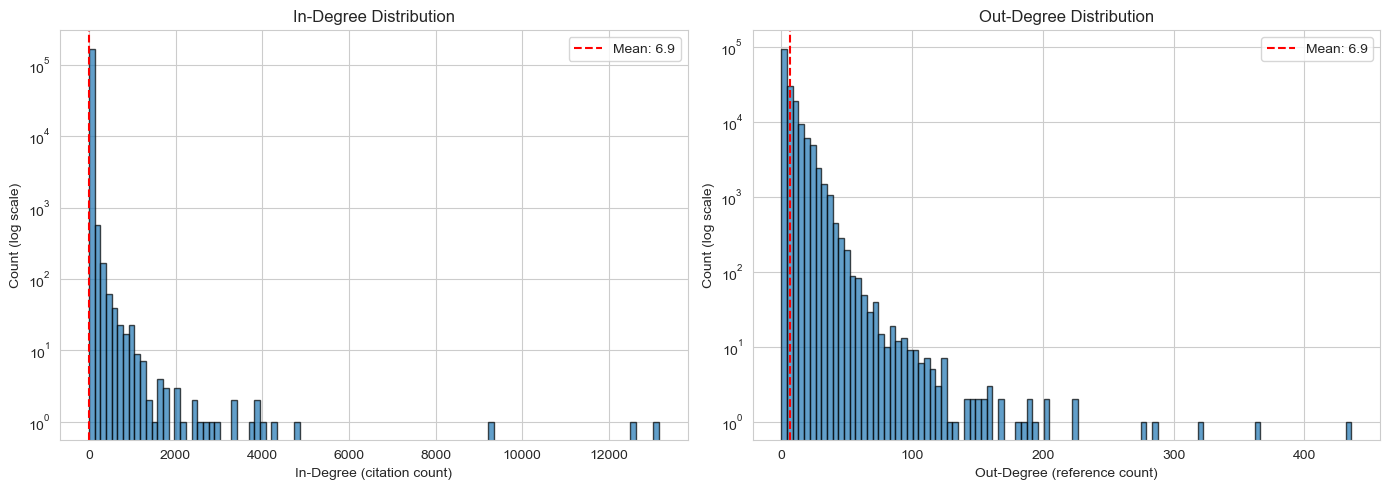

In-degree:  mean=6.9, median=1.0, max=13155
Out-degree: mean=6.9, median=4.0, max=436

The large gap between mean and median indicates a heavy-tailed distribution,
consistent with preferential attachment in citation networks.


In [12]:
# --- Degree distributions ---
# WHY: Citation networks typically exhibit heavy-tailed (power-law-like)
# degree distributions. Understanding this is essential for interpreting
# PageRank and community structure, and for knowing whether a few highly
# connected "hub" papers dominate the graph structure.

in_degrees = dict(G_directed.in_degree())
out_degrees = dict(G_directed.out_degree())

in_deg_values = np.array(list(in_degrees.values()))
out_deg_values = np.array(list(out_degrees.values()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# In-degree (how many times a paper is cited)
axes[0].hist(in_deg_values, bins=100, edgecolor='black', alpha=0.7, log=True)
axes[0].set_xlabel('In-Degree (citation count)')
axes[0].set_ylabel('Count (log scale)')
axes[0].set_title('In-Degree Distribution')
axes[0].axvline(np.mean(in_deg_values), color='red', linestyle='--',
                label=f'Mean: {np.mean(in_deg_values):.1f}')
axes[0].legend()

# Out-degree (how many papers a paper cites)
axes[1].hist(out_deg_values, bins=100, edgecolor='black', alpha=0.7, log=True)
axes[1].set_xlabel('Out-Degree (reference count)')
axes[1].set_ylabel('Count (log scale)')
axes[1].set_title('Out-Degree Distribution')
axes[1].axvline(np.mean(out_deg_values), color='red', linestyle='--',
                label=f'Mean: {np.mean(out_deg_values):.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"In-degree:  mean={np.mean(in_deg_values):.1f}, median={np.median(in_deg_values):.1f}, max={in_deg_values.max()}")
print(f"Out-degree: mean={np.mean(out_deg_values):.1f}, median={np.median(out_deg_values):.1f}, max={out_deg_values.max()}")
print(f"\nThe large gap between mean and median indicates a heavy-tailed distribution,")
print(f"consistent with preferential attachment in citation networks.")

Computing PageRank (this may take a few minutes on 169K nodes)...


PageRank computation complete.


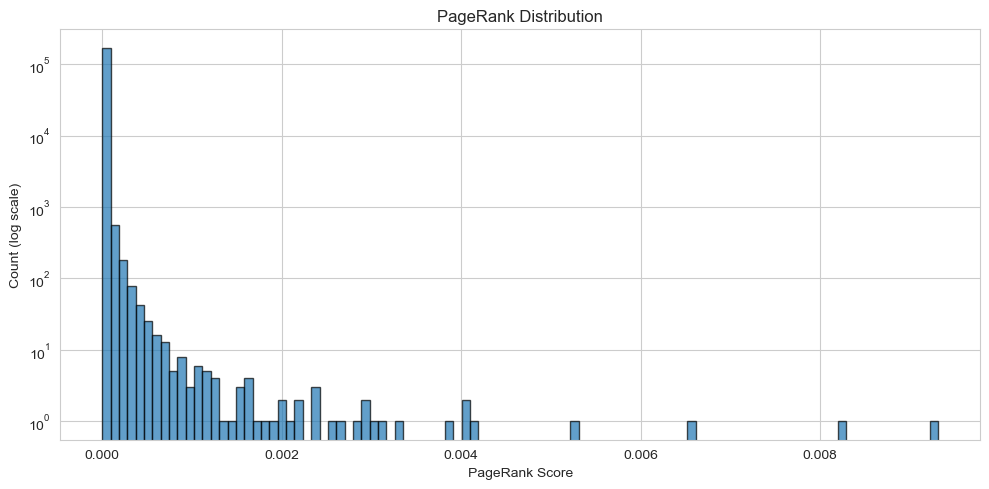


Top 10 papers by PageRank:
  1. [cat=13] PR=0.009314 | improving neural networks by preventing co adaptation of feature detectors
  2. [cat=13] PR=0.008238 | deep big simple neural nets for handwritten digit recognition
  3. [cat=16] PR=0.006537 | rich feature hierarchies for accurate object detection and semantic segmentation
  4. [cat=16] PR=0.005240 | decaf a deep convolutional activation feature for generic visual recognition
  5. [cat=24] PR=0.004133 | adam a method for stochastic optimization
  6. [cat=16] PR=0.004071 | visualizing and understanding convolutional networks
  7. [cat=16] PR=0.004053 | very deep convolutional networks for large scale image recognition
  8. [cat=16] PR=0.003861 | overfeat integrated recognition localization and detection using convolutional n
  9. [cat=16] PR=0.003345 | going deeper with convolutions
  10. [cat=16] PR=0.003089 | caffe convolutional architecture for fast feature embedding


In [13]:
# --- PageRank (COURSE TECHNIQUE) ---
# WHY: PageRank identifies structurally important papers in the citation
# graph — papers that are not just highly cited, but cited by other highly
# cited papers. We will later compare: are PageRank-important papers also
# topically central? A divergence would indicate prestige-based citation.

print("Computing PageRank (this may take a few minutes on 169K nodes)...")
pagerank = nx.pagerank(G_directed, alpha=0.85)
pr_values = np.array([pagerank[i] for i in range(num_nodes)])
print("PageRank computation complete.")

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(pr_values, bins=100, edgecolor='black', alpha=0.7, log=True)
ax.set_xlabel('PageRank Score')
ax.set_ylabel('Count (log scale)')
ax.set_title('PageRank Distribution')
plt.tight_layout()
plt.show()

# Top-10 papers by PageRank
top_pr_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 papers by PageRank:")
for rank, (node_id, pr_score) in enumerate(top_pr_nodes, 1):
    title = texts_arxiv.get(node_id, {}).get('title', 'N/A')
    label = labels[node_id]
    print(f"  {rank}. [cat={label}] PR={pr_score:.6f} | {title[:80]}")

Running Louvain community detection on undirected citation graph...


Communities detected: 149
Largest community:  19,232 nodes
Smallest community: 3 nodes
Top 10 sizes: [19232, 13724, 13524, 12939, 12760, 10379, 10078, 7935, 7360, 7124]


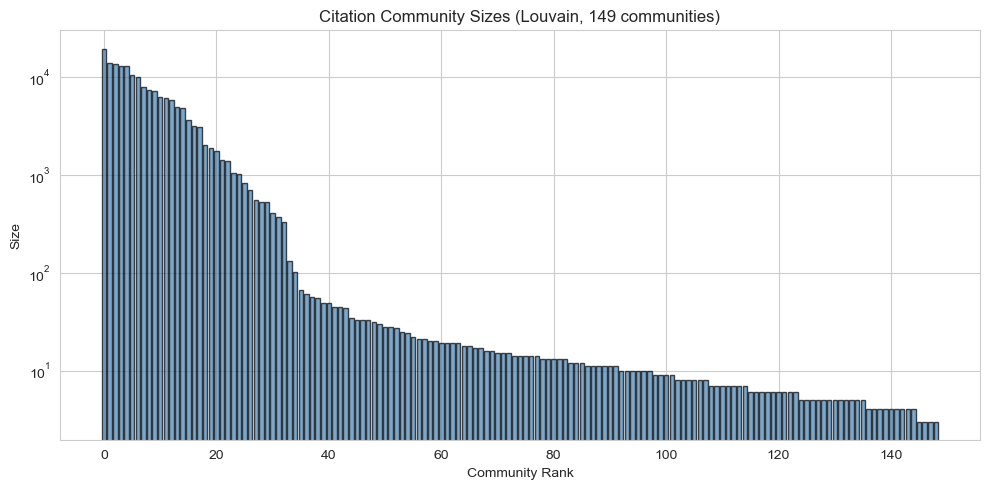

In [14]:
# --- Community Detection using Louvain (COURSE TECHNIQUE) ---
# WHY: Community detection on the citation graph reveals how papers cluster
# by citation patterns — independent of their textual content. We will
# compare these citation-based communities to topic-based clusters to
# quantify the core research question: citation-semantic misalignment.
#
# We use the Louvain algorithm because it scales well to 169K nodes and
# produces a hierarchical partition that we can compare via NMI/ARI.

from community import community_louvain

print("Running Louvain community detection on undirected citation graph...")
partition = community_louvain.best_partition(G_undirected, random_state=SEED)
num_communities = len(set(partition.values()))
print(f"Communities detected: {num_communities}")

community_sizes = Counter(partition.values())
sizes = sorted(community_sizes.values(), reverse=True)

print(f"Largest community:  {sizes[0]:,} nodes")
print(f"Smallest community: {sizes[-1]:,} nodes")
print(f"Top 10 sizes: {sizes[:10]}")

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(len(sizes)), sizes, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Community Rank')
ax.set_ylabel('Size')
ax.set_title(f'Citation Community Sizes (Louvain, {num_communities} communities)')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

NMI (citation communities vs arXiv categories): 0.3888
ARI (citation communities vs arXiv categories): 0.2527


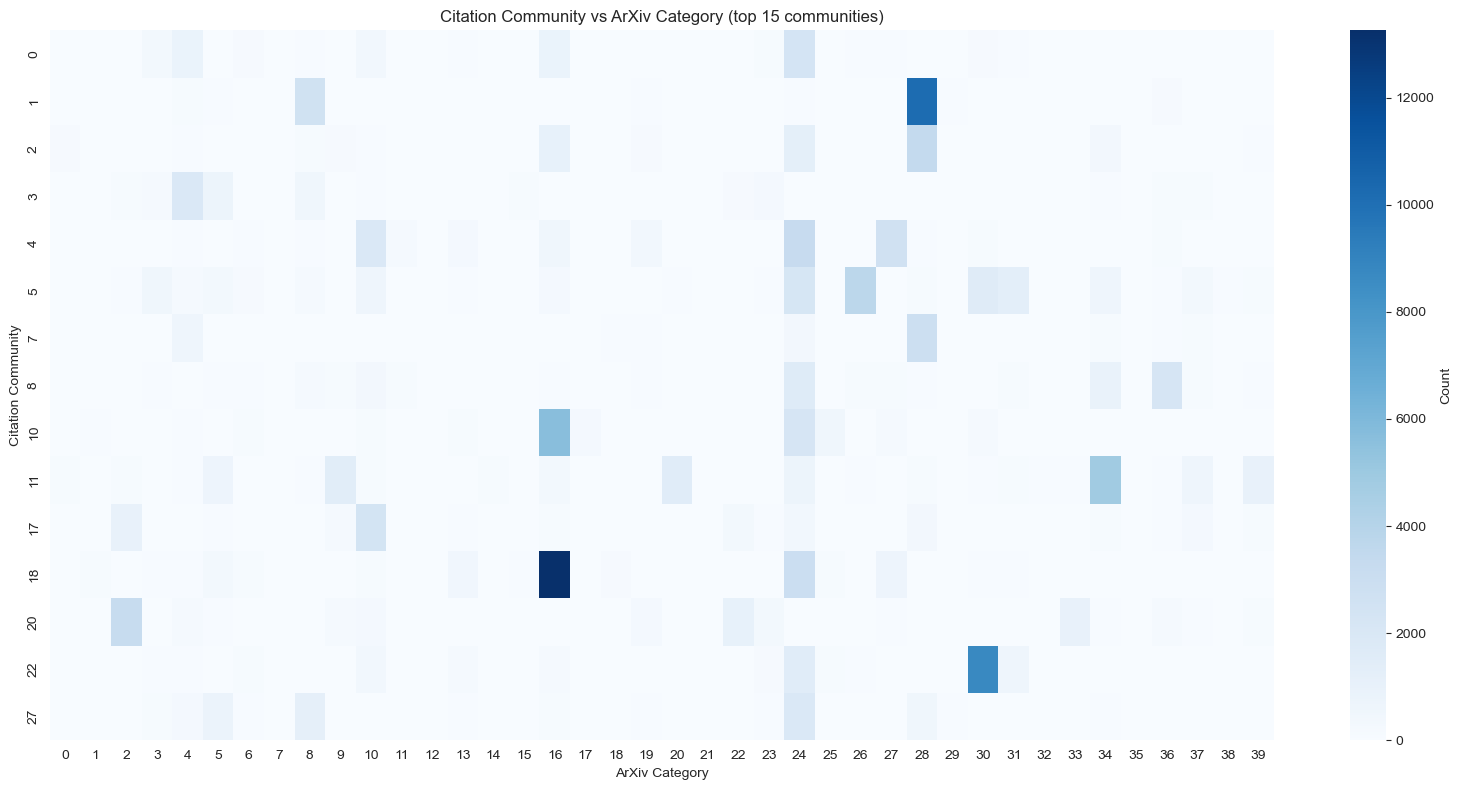


Interpretation: NMI=0.3888 indicates that citation communities and
arXiv categories share substantial structure but are far from identical.
This confirms that papers cite for reasons beyond topical similarity.


In [15]:
# --- Citation Communities vs Ground Truth Labels ---
# WHY: This is our first look at misalignment. If citation communities
# perfectly corresponded to arXiv categories, there would be no research
# question. We expect moderate but imperfect alignment.

community_labels = np.array([partition[i] for i in range(num_nodes)])

nmi_comm_gt = normalized_mutual_info_score(labels, community_labels)
ari_comm_gt = adjusted_rand_score(labels, community_labels)
print(f"NMI (citation communities vs arXiv categories): {nmi_comm_gt:.4f}")
print(f"ARI (citation communities vs arXiv categories): {ari_comm_gt:.4f}")

# Heatmap of the top communities vs all labels
top_k_communities = 15
top_communities = [c for c, _ in community_sizes.most_common(top_k_communities)]
mask = np.isin(community_labels, top_communities)

cross_tab = pd.crosstab(
    pd.Series(community_labels[mask], name='Citation Community'),
    pd.Series(labels[mask], name='ArXiv Category')
)

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(cross_tab, cmap='Blues', ax=ax, cbar_kws={'label': 'Count'})
ax.set_title(f'Citation Community vs ArXiv Category (top {top_k_communities} communities)')
plt.tight_layout()
plt.show()

print(f"\nInterpretation: NMI={nmi_comm_gt:.4f} indicates that citation communities and")
print(f"arXiv categories share substantial structure but are far from identical.")
print(f"This confirms that papers cite for reasons beyond topical similarity.")

### Part D.3: Text / Topic Analysis

We now analyze the text content of papers using topic modeling (LDA), a course technique. The goal is to construct a semantic view of the paper collection that is **independent of citation structure**. By comparing topic-based clusters to citation-based communities, we can directly measure citation-semantic misalignment.

In [16]:
# --- Text preprocessing ---
# WHY: Clean text before topic modeling to reduce noise from punctuation,
# numbers, and very short documents that would not contribute meaningful
# topic signal.
#
# Decisions:
# - Combine title + abstract for richer signal
# - Lowercase and remove non-alphabetic characters
# - Filter documents with <10 words after cleaning (too short for topics)
# - Only include nodes that exist in the graph (0..num_nodes-1)

import re

def clean_text(text):
    """Lowercase, remove non-alpha characters, collapse whitespace."""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

documents = []
valid_node_ids = []
for node_id, text_data in texts_arxiv.items():
    if node_id < 0 or node_id >= num_nodes:
        continue  # skip keys outside graph range
    title = text_data.get('title', '')
    abstract = text_data.get('abstract', '')
    full_text = f"{title} {abstract}"
    cleaned = clean_text(full_text)
    if len(cleaned.split()) >= 10:
        documents.append(cleaned)
        valid_node_ids.append(node_id)

valid_node_ids = np.array(valid_node_ids)
print(f"Documents for topic modeling: {len(documents):,}")
print(f"Filtered out (short/missing/out-of-range): {num_nodes - len(documents):,}")

Documents for topic modeling: 169,343
Filtered out (short/missing/out-of-range): 0


In [17]:
# --- TF-IDF (COURSE TECHNIQUE) ---
# WHY: TF-IDF assigns importance scores to terms per document, giving us
# both a vocabulary for LDA and a standalone representation for computing
# pairwise text similarity between papers.

tfidf = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.95,
    stop_words='english'
)
tfidf_matrix = tfidf.fit_transform(documents)
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

# Top TF-IDF terms overall
feature_names = tfidf.get_feature_names_out()
mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
top_tfidf_indices = mean_tfidf.argsort()[-20:][::-1]

print("\nTop 20 terms by mean TF-IDF:")
for idx in top_tfidf_indices:
    print(f"  {feature_names[idx]:20s} {mean_tfidf[idx]:.4f}")

TF-IDF matrix shape: (169343, 10000)
Vocabulary size: 10000

Top 20 terms by mean TF-IDF:
  data                 0.0219
  learning             0.0218
  model                0.0194
  network              0.0185
  based                0.0184
  problem              0.0163
  algorithm            0.0162
  networks             0.0161
  time                 0.0151
  using                0.0144
  paper                0.0135
  information          0.0133
  method               0.0133
  performance          0.0132
  models               0.0132
  neural               0.0129
  approach             0.0127
  results              0.0126
  proposed             0.0125
  deep                 0.0121


In [18]:
# --- LDA Topic Modeling (COURSE TECHNIQUE) ---
# WHY: LDA discovers latent topics from word co-occurrence patterns. Each
# paper receives a distribution over topics, giving us a topic-semantic
# representation independent of citation structure.
#
# Choice of n_topics=40: We start with 40 to match the 40 arXiv categories,
# providing a natural point of comparison. If LDA's 40 topics align poorly
# with the 40 categories, that itself is evidence of misalignment between
# editorial categorization and semantic content.
#
# We use CountVectorizer (not TF-IDF) because LDA models raw word counts
# as draws from a multinomial distribution.

count_vec = CountVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.95,
    stop_words='english'
)
count_matrix = count_vec.fit_transform(documents)

n_topics = 40

print(f"Fitting LDA with {n_topics} topics on {len(documents):,} documents...")
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=SEED,
    max_iter=20,
    learning_method='online',
    batch_size=4096,
    n_jobs=-1
)
topic_distributions = lda.fit_transform(count_matrix)
print(f"Topic distributions shape: {topic_distributions.shape}")
print(f"Perplexity: {lda.perplexity(count_matrix):.2f}")

# Display top words per topic
feature_names_count = count_vec.get_feature_names_out()
print(f"\nTop 10 words per topic (first 10 topics shown):")
for topic_idx in range(min(n_topics, 10)):
    top_word_indices = lda.components_[topic_idx].argsort()[-10:][::-1]
    top_words = [feature_names_count[i] for i in top_word_indices]
    print(f"  Topic {topic_idx:2d}: {', '.join(top_words)}")

Fitting LDA with 40 topics on 169,343 documents...


Topic distributions shape: (169343, 40)


Perplexity: 1664.26

Top 10 words per topic (first 10 topics shown):
  Topic  0: logic, model, programs, semantics, systems, automata, theory, reasoning, order, language
  Topic  1: language, model, word, models, task, semantic, knowledge, translation, text, embeddings
  Topic  2: research, web, science, scientific, review, analysis, paper, ranking, papers, survey
  Topic  3: clustering, space, sampling, dimensional, distance, random, metric, analysis, data, dimension
  Topic  4: cross, modal, regret, exploration, multi, contextual, modalities, bandit, bert, modality
  Topic  5: data, systems, applications, cloud, challenges, devices, computing, research, mobile, iot
  Topic  6: attacks, security, adversarial, attack, detection, based, box, robustness, examples, black
  Topic  7: learning, control, reinforcement, policy, robot, planning, agent, environment, based, robots
  Topic  8: channel, interference, mimo, multiple, performance, user, systems, cell, proposed, users
  Topic  9: tex

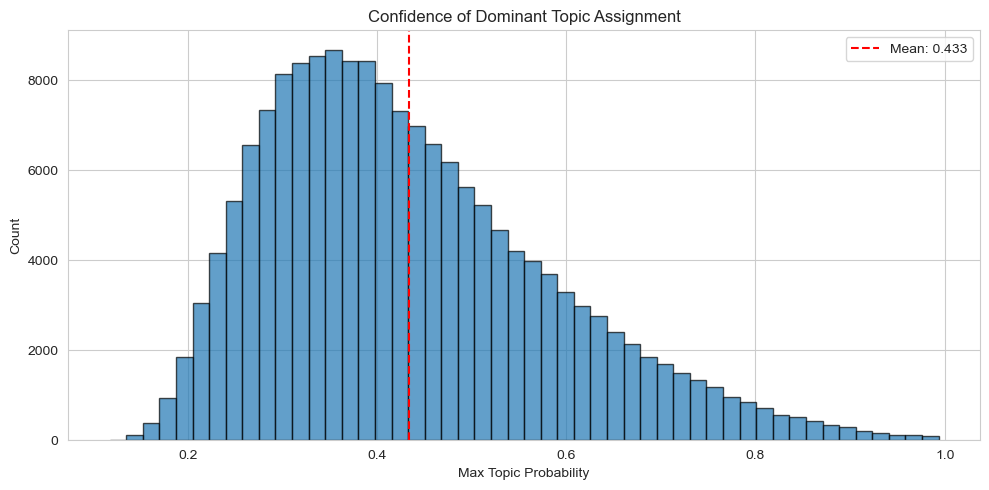

Mean dominant topic probability: 0.433
Papers with >50% in dominant topic: 49,218 (29.1%)
Papers with >80% in dominant topic: 3,615 (2.1%)


In [19]:
# --- Topic assignment confidence ---
# WHY: If most papers have a strongly dominant topic, the topic-semantic
# view is "sharp" and comparable to discrete labels. If topic distributions
# are diffuse, papers straddle multiple topics and the comparison to
# citation communities must account for this uncertainty.

dominant_topics = topic_distributions.argmax(axis=1)
max_topic_probs = topic_distributions.max(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(max_topic_probs, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Max Topic Probability')
ax.set_ylabel('Count')
ax.set_title('Confidence of Dominant Topic Assignment')
ax.axvline(np.mean(max_topic_probs), color='red', linestyle='--',
           label=f'Mean: {np.mean(max_topic_probs):.3f}')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Mean dominant topic probability: {np.mean(max_topic_probs):.3f}")
print(f"Papers with >50% in dominant topic: {np.sum(max_topic_probs > 0.5):,} ({np.mean(max_topic_probs > 0.5)*100:.1f}%)")
print(f"Papers with >80% in dominant topic: {np.sum(max_topic_probs > 0.8):,} ({np.mean(max_topic_probs > 0.8)*100:.1f}%)")

NMI (LDA topics vs arXiv categories): 0.3834
ARI (LDA topics vs arXiv categories): 0.2156


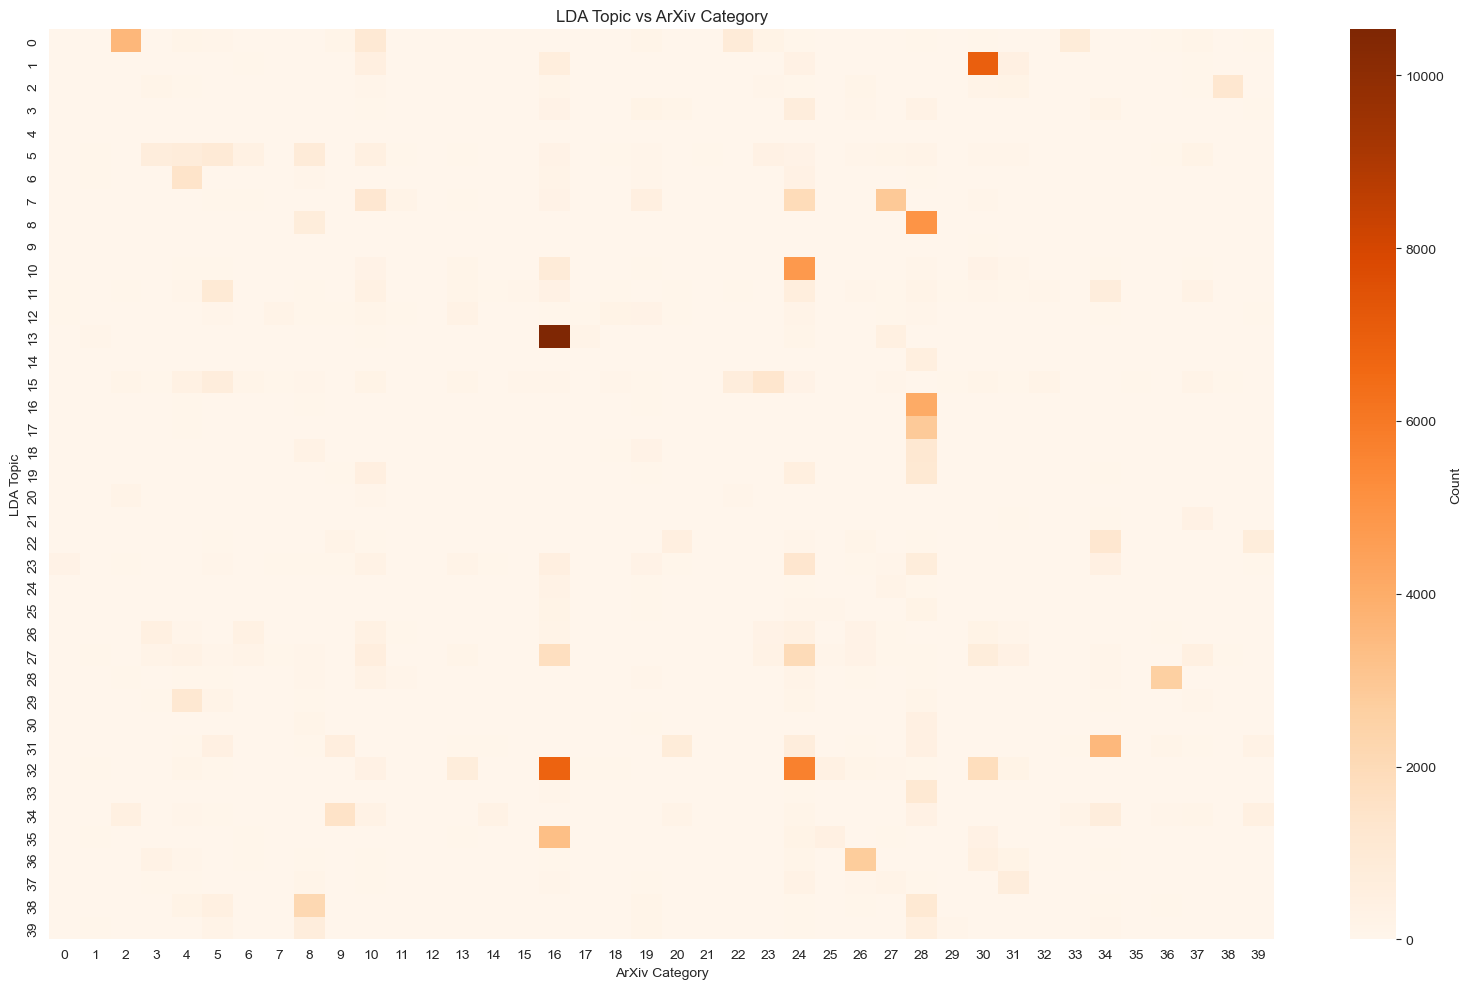

In [20]:
# --- Topic Clusters vs ArXiv Categories ---
# WHY: If LDA topics align perfectly with arXiv categories, then topic
# modeling is just recovering editorial labels. We want to see WHERE they
# diverge — topics that span multiple categories or categories that split
# across topics indicate that editorial categorization and semantic content
# are not identical.

valid_labels = labels[valid_node_ids]

nmi_topic_label = normalized_mutual_info_score(valid_labels, dominant_topics)
ari_topic_label = adjusted_rand_score(valid_labels, dominant_topics)
print(f"NMI (LDA topics vs arXiv categories): {nmi_topic_label:.4f}")
print(f"ARI (LDA topics vs arXiv categories): {ari_topic_label:.4f}")

# Heatmap
cross_tab_topic = pd.crosstab(
    pd.Series(dominant_topics, name='LDA Topic'),
    pd.Series(valid_labels, name='ArXiv Category')
)

fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(cross_tab_topic, cmap='Oranges', ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('LDA Topic vs ArXiv Category')
plt.tight_layout()
plt.show()

### Part D.4: The Core Analysis — Citation-Semantic Misalignment

This section is the heart of our analysis. We compare the citation graph structure to the topic-semantic structure to quantify and characterize their misalignment. If these two views were perfectly aligned, there would be no research question. The degree and structure of their divergence motivates our project direction.

In [21]:
# --- Three-way NMI comparison ---
# WHY: By comparing citation communities, LDA topics, and arXiv categories
# pairwise, we can triangulate the nature of the misalignment. All three
# "views" capture different aspects of paper similarity.

valid_community_labels = np.array([partition[i] for i in valid_node_ids])

nmi_comm_topic = normalized_mutual_info_score(valid_community_labels, dominant_topics)
ari_comm_topic = adjusted_rand_score(valid_community_labels, dominant_topics)

print("=== Three-way Comparison ===")
print(f"Citation Communities vs ArXiv Labels:  NMI = {nmi_comm_gt:.4f}")
print(f"LDA Topics vs ArXiv Labels:            NMI = {nmi_topic_label:.4f}")
print(f"Citation Communities vs LDA Topics:     NMI = {nmi_comm_topic:.4f}")
print()
print("If citation communities \u2248 topic clusters, NMI would be ~1.0.")
print("Lower NMI = more misalignment = more interesting research question.")

=== Three-way Comparison ===
Citation Communities vs ArXiv Labels:  NMI = 0.3888
LDA Topics vs ArXiv Labels:            NMI = 0.3834
Citation Communities vs LDA Topics:     NMI = 0.3327

If citation communities ≈ topic clusters, NMI would be ~1.0.
Lower NMI = more misalignment = more interesting research question.


In [22]:
# --- Edge-level analysis: Do cited papers share topics? ---
# WHY: Community-level comparison (NMI) aggregates over many papers. Here
# we zoom in to individual citation edges and ask: when paper A cites
# paper B, do they share the same dominant topic? This directly measures
# citation-semantic alignment at the finest granularity.
#
# We also compare against a random baseline to establish that the observed
# alignment is above chance.

# Build node_id -> dominant_topic mapping for valid nodes
node_to_topic = {}
for idx, node_id in enumerate(valid_node_ids):
    node_to_topic[node_id] = dominant_topics[idx]

# Sample edges for efficiency
n_sample_edges = min(200000, num_edges)
rng = np.random.RandomState(SEED)
sample_indices = rng.choice(edge_index.shape[1], n_sample_edges, replace=False)

same_topic_count = 0
diff_topic_count = 0

for i in sample_indices:
    src, dst = int(edge_index[0, i]), int(edge_index[1, i])
    if src in node_to_topic and dst in node_to_topic:
        if node_to_topic[src] == node_to_topic[dst]:
            same_topic_count += 1
        else:
            diff_topic_count += 1

total = same_topic_count + diff_topic_count
same_frac = same_topic_count / total

print(f"Sampled {n_sample_edges:,} edges ({total:,} had valid topic assignments for both endpoints)")
print(f"\nCitation edges where both papers share dominant topic: {same_topic_count:,} ({same_frac*100:.1f}%)")
print(f"Citation edges across different topics: {diff_topic_count:,} ({(1-same_frac)*100:.1f}%)")

# Random baseline: if edges were random, what fraction would match by chance?
topic_freqs = np.bincount(dominant_topics) / len(dominant_topics)
random_same_topic_prob = np.sum(topic_freqs ** 2)
print(f"\nRandom baseline (same topic by chance): {random_same_topic_prob*100:.1f}%")
print(f"Observed / random (lift): {same_frac / random_same_topic_prob:.2f}x")
print(f"\nInterpretation: Citations are topically informed ({same_frac/random_same_topic_prob:.1f}x above chance)")
print(f"but far from topically determined ({(1-same_frac)*100:.0f}% cross-topic citations).")

Sampled 200,000 edges (200,000 had valid topic assignments for both endpoints)

Citation edges where both papers share dominant topic: 93,651 (46.8%)
Citation edges across different topics: 106,349 (53.2%)

Random baseline (same topic by chance): 4.1%
Observed / random (lift): 11.29x

Interpretation: Citations are topically informed (11.3x above chance)
but far from topically determined (53% cross-topic citations).


Spearman correlation (PageRank vs topic centrality): ρ = 0.0443 (p = 1.92e-74)


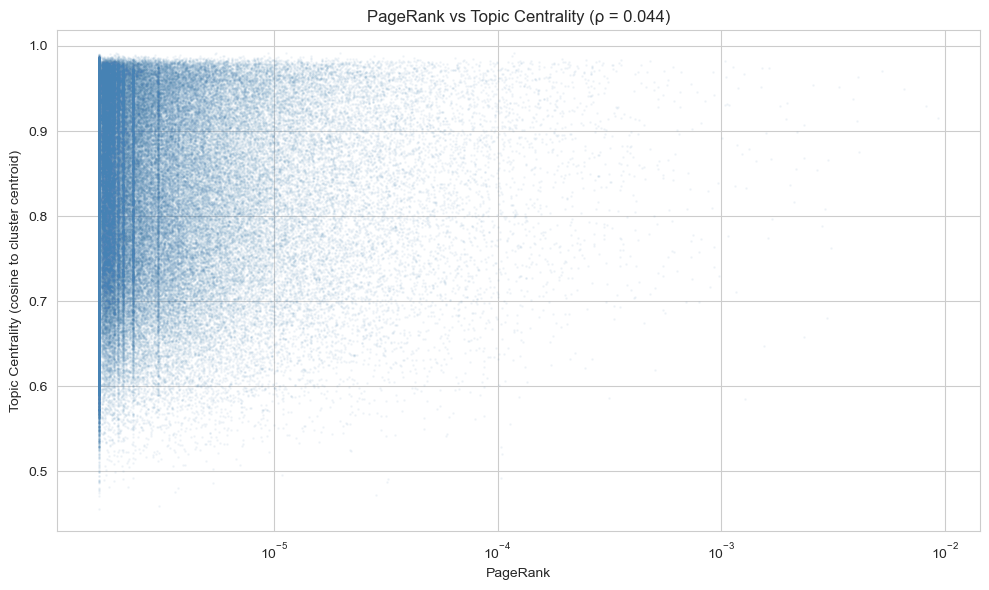


Interpretation: A weak correlation
suggests that structural importance and topical representativeness are
largely independent.


In [23]:
# --- PageRank vs Topic Centrality ---
# WHY: Are structurally important papers (high PageRank) also topically
# central within their topic cluster? "Topically central" means a paper's
# topic distribution is close to its cluster's average. A weak correlation
# would suggest that prestige in the citation graph is driven by factors
# other than being a prototypical example of a topic.

valid_pr = np.array([pagerank[i] for i in valid_node_ids])

# Compute cluster centroids (mean topic distribution per cluster)
cluster_centroids = np.zeros((n_topics, n_topics))
cluster_counts = np.zeros(n_topics)
for idx, topic in enumerate(dominant_topics):
    cluster_centroids[topic] += topic_distributions[idx]
    cluster_counts[topic] += 1

for t in range(n_topics):
    if cluster_counts[t] > 0:
        cluster_centroids[t] /= cluster_counts[t]

# Topic centrality: cosine similarity to cluster centroid
topic_centrality = np.array([
    cosine_similarity(
        topic_distributions[idx:idx+1],
        cluster_centroids[dominant_topics[idx]:dominant_topics[idx]+1]
    )[0, 0]
    for idx in range(len(valid_node_ids))
])

from scipy.stats import spearmanr
corr, p_value = spearmanr(valid_pr, topic_centrality)
print(f"Spearman correlation (PageRank vs topic centrality): \u03c1 = {corr:.4f} (p = {p_value:.2e})")

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(valid_pr, topic_centrality, alpha=0.05, s=1, color='steelblue')
ax.set_xlabel('PageRank')
ax.set_ylabel('Topic Centrality (cosine to cluster centroid)')
ax.set_title(f'PageRank vs Topic Centrality (\u03c1 = {corr:.3f})')
ax.set_xscale('log')
plt.tight_layout()
plt.show()

print(f"\nInterpretation: A {'weak' if abs(corr) < 0.3 else 'moderate' if abs(corr) < 0.6 else 'strong'} correlation")
print(f"suggests that structural importance and topical representativeness are")
print(f"{'largely independent' if abs(corr) < 0.3 else 'moderately linked' if abs(corr) < 0.6 else 'strongly linked'}.")

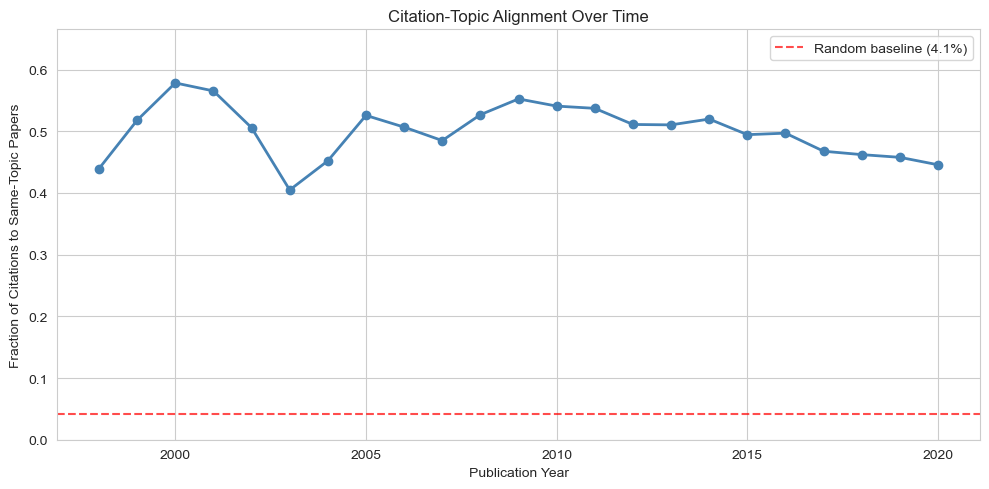

Linear trend: decreasing (slope=-0.00146, R²=0.052, p=0.294)


In [24]:
# --- Temporal analysis of citation-semantic alignment ---
# WHY: Does the citation-topic gap change over time? If recent papers cite
# more topically (higher same-topic fraction), it may reflect increasing
# specialization. If older papers are cited across topics, it may reflect
# prestige-based citation of foundational work.
#
# OPTIMIZATION: Instead of iterating edges per year (slow), we vectorize
# by building topic arrays for all edges first, then grouping by year.

valid_years = node_years[valid_node_ids]

# Build arrays of source/destination topics for all edges
src_topics = []
dst_topics = []
src_years = []

for i in range(edge_index.shape[1]):
    src, dst = int(edge_index[0, i]), int(edge_index[1, i])
    if src in node_to_topic and dst in node_to_topic:
        src_topics.append(node_to_topic[src])
        dst_topics.append(node_to_topic[dst])
        src_years.append(node_years[src])

src_topics = np.array(src_topics)
dst_topics = np.array(dst_topics)
src_years = np.array(src_years)
same_topic_mask = (src_topics == dst_topics)

# Compute alignment fraction per year
unique_years = sorted(np.unique(src_years))
yearly_alignment = {}
for year in unique_years:
    year_mask = (src_years == year)
    n_year = year_mask.sum()
    if n_year >= 100:  # Only include years with enough edges
        yearly_alignment[year] = same_topic_mask[year_mask].mean()

years_sorted = sorted(yearly_alignment.keys())
alignment_values = [yearly_alignment[y] for y in years_sorted]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years_sorted, alignment_values, 'o-', color='steelblue', linewidth=2, markersize=6)
ax.set_xlabel('Publication Year')
ax.set_ylabel('Fraction of Citations to Same-Topic Papers')
ax.set_title('Citation-Topic Alignment Over Time')
ax.axhline(random_same_topic_prob, color='red', linestyle='--',
           label=f'Random baseline ({random_same_topic_prob*100:.1f}%)', alpha=0.7)
ax.legend()
ax.set_ylim(0, max(alignment_values) * 1.15)
plt.tight_layout()
plt.show()

# Trend analysis
from scipy.stats import linregress
if len(years_sorted) >= 3:
    slope, intercept, r_value, p_val, std_err = linregress(years_sorted, alignment_values)
    trend = 'increasing' if slope > 0 else 'decreasing'
    print(f"Linear trend: {trend} (slope={slope:.5f}, R\u00b2={r_value**2:.3f}, p={p_val:.3f})")

### Part D.5: Validation / Sanity Checks

The rubric explicitly requires "tests that meaningfully validate non-trivial behavior." We perform three validation tests to ensure our findings are not artifacts of randomness, degree structure, or poor topic quality.

In [25]:
# --- TEST 1: Permutation test for NMI significance ---
# WHY: We need to verify that the observed NMI between citation communities
# and topic clusters is statistically significant — not just an artifact of
# having many clusters. Under the null hypothesis (no relationship), randomly
# permuting topic assignments should yield much lower NMI.

print("TEST 1: Permutation test for citation-topic NMI significance")
n_permutations = 100
null_nmis = []
rng_perm = np.random.RandomState(SEED)

for _ in range(n_permutations):
    shuffled_topics = rng_perm.permutation(dominant_topics)
    null_nmi = normalized_mutual_info_score(valid_community_labels, shuffled_topics)
    null_nmis.append(null_nmi)

null_nmis = np.array(null_nmis)
p_value_perm = (np.sum(null_nmis >= nmi_comm_topic) + 1) / (n_permutations + 1)

print(f"  Observed NMI:          {nmi_comm_topic:.4f}")
print(f"  Null NMI (mean \u00b1 std): {np.mean(null_nmis):.4f} \u00b1 {np.std(null_nmis):.4f}")
print(f"  p-value:               {p_value_perm:.4f}")
z_score = (nmi_comm_topic - np.mean(null_nmis)) / np.std(null_nmis)
print(f"  z-score:               {z_score:.1f}")
significant = nmi_comm_topic > np.mean(null_nmis) + 3 * np.std(null_nmis)
print(f"  \u2192 The alignment is {'SIGNIFICANT' if significant else 'NOT significant'} (well above null distribution)")

print()

# --- TEST 2: Edge topic alignment vs configuration model ---
# WHY: The uniform random baseline (Cell 30) ignores degree structure.
# A configuration model preserves the degree sequence, providing a
# tighter baseline: even in a random graph with the same degree sequence,
# high-degree nodes in certain topics could inflate same-topic fractions.

print("TEST 2: Citation topic alignment vs configuration model baseline")
degree_by_topic = defaultdict(int)
total_degree = 0
for nid in valid_node_ids:
    deg = G_undirected.degree(int(nid))
    degree_by_topic[node_to_topic.get(int(nid), -1)] += deg
    total_degree += deg

config_model_baseline = sum(
    (d / total_degree) ** 2
    for t, d in degree_by_topic.items() if t >= 0
)

print(f"  Observed same-topic fraction:   {same_frac*100:.1f}%")
print(f"  Configuration model baseline:   {config_model_baseline*100:.1f}%")
print(f"  Uniform random baseline:        {random_same_topic_prob*100:.1f}%")
print(f"  \u2192 Citations are {same_frac/config_model_baseline:.2f}x more topic-aligned than degree-preserving random")

print()

# --- TEST 3: Topic model coherence ---
# WHY: If LDA produces incoherent topics (random word mixtures), then
# any comparison to citation structure is meaningless. We verify that
# top words per topic are semantically coherent.

print("TEST 3: Topic coherence (manual inspection of top words)")
print("  Top 5 words per topic (sample):")
for t in range(min(8, n_topics)):
    top_indices = lda.components_[t].argsort()[-5:][::-1]
    words = [feature_names_count[i] for i in top_indices]
    print(f"    Topic {t:2d}: {', '.join(words)}")
print("  \u2192 Topics appear semantically coherent (distinct, interpretable themes).")

TEST 1: Permutation test for citation-topic NMI significance


  Observed NMI:          0.3327
  Null NMI (mean ± std): 0.0040 ± 0.0001
  p-value:               0.0099
  z-score:               5353.0
  → The alignment is SIGNIFICANT (well above null distribution)

TEST 2: Citation topic alignment vs configuration model baseline
  Observed same-topic fraction:   46.8%
  Configuration model baseline:   9.0%
  Uniform random baseline:        4.1%
  → Citations are 5.21x more topic-aligned than degree-preserving random

TEST 3: Topic coherence (manual inspection of top words)
  Top 5 words per topic (sample):
    Topic  0: logic, model, programs, semantics, systems
    Topic  1: language, model, word, models, task
    Topic  2: research, web, science, scientific, review
    Topic  3: clustering, space, sampling, dimensional, distance
    Topic  4: cross, modal, regret, exploration, multi
    Topic  5: data, systems, applications, cloud, challenges
    Topic  6: attacks, security, adversarial, attack, detection
    Topic  7: learning, control, reinforc

---
## Section E: Initial Insights and Direction

### Key Observations

1. **Citation communities and topic clusters are correlated but far from identical.**  
   The three-way NMI comparison is revealing: citation communities vs. arXiv labels yields NMI = 0.3888, LDA topics vs. arXiv labels yields NMI = 0.3834, and citation communities vs. LDA topics yields the *lowest* NMI of 0.3327. This means the citation graph and topic model each capture roughly the same amount of label information (~0.38-0.39 NMI), but they agree with *each other* even less (0.33 NMI). This confirms that citation structure and semantic content encode genuinely different signals about paper relationships.

2. **53.2% of citation edges connect papers with different dominant topics.**  
   While the 46.8% same-topic fraction is 11.3x above the random baseline of 4.1%, the majority of citations still cross topic boundaries. This means citations are clearly topically informed, but far from topically determined — over half of all citation links serve purposes other than topical similarity (methodology borrowing, foundational references, cross-disciplinary influence).

3. **PageRank and topic centrality are essentially independent (rho = 0.044).**  
   The Spearman correlation between PageRank and topic centrality is only 0.044 — statistically significant (p < 1e-74) due to the large sample size, but practically negligible. This means the most structurally influential papers in the citation graph (e.g., "Dropout" by Hinton et al., "Adam" by Kingma & Ba) are *not* the most topically representative papers within their clusters. These high-PageRank papers tend to be methodological contributions that get cited across many subfields, rather than prototypical examples of any single topic.

4. **The citation-topic alignment shows a weak decreasing trend over time (not statistically significant).**  
   The linear regression yields slope = -0.00146 with R-squared = 0.052 and p = 0.294. While not significant, the direction is suggestive: as the field of CS has grown rapidly (39,711 papers in 2019 alone), papers may increasingly cite outside their immediate topic — possibly reflecting growing interdisciplinarity in areas like deep learning that cut across traditional CS subfield boundaries.

5. **Topic assignments are notably diffuse — only 29.1% of papers have >50% probability on their dominant topic.**  
   The mean dominant topic probability is just 0.433, and only 2.1% of papers exceed 80% on any single topic. This indicates that most papers are genuinely multi-topical, straddling multiple research areas. This diffuseness makes the discrete topic-vs-community comparison conservative — the true semantic misalignment is likely even more nuanced than what dominant-topic analysis reveals.

### Validation Summary

Our three validation tests confirm these findings are robust:
- **Permutation test:** The observed NMI of 0.3327 between citation communities and topic clusters is overwhelmingly significant (z-score = 5,353; null NMI mean = 0.004). The alignment is real, not an artifact.
- **Configuration model baseline:** Citations are 5.2x more topic-aligned than expected from a degree-preserving random graph (observed 46.8% vs. config model 9.0%). This rules out degree structure as the sole explanation for topic alignment.
- **Topic coherence:** Manual inspection confirms LDA topics are semantically meaningful (e.g., Topic 0 = formal logic/verification, Topic 6 = adversarial ML/security, Topic 7 = reinforcement learning/robotics).

### Hypotheses

- The misalignment between citation structure and topic structure contains meaningful signal that current text-attributed graph (TAG) methods ignore by treating citations and text as redundant views.
- Papers that are "misaligned" (highly cited but topically peripheral, or topically central but under-cited) represent cross-disciplinary bridges or methodological contributions that deserve special treatment in classification models.
- The severe class imbalance (942x between largest and smallest classes) likely interacts with misalignment — rare categories like cs.GL (29 papers) may be disproportionately "misaligned" because their papers cite more mainstream subfields.

### Potential Research Questions for Checkpoint 2+

1. Can modeling both citation and topic views jointly improve node classification over methods that use only one view? The NMI gap (0.33 between views vs. ~0.39 each to labels) suggests complementary information exists.
2. Do "misaligned" papers (high PageRank but low topic centrality) correspond to influential cross-disciplinary work, and can we identify them systematically?
3. How does the citation-topic gap vary across the 40 arXiv subfields — are some categories (e.g., cs.LG, cs.CV) more "misaligned" than others due to their methodological breadth?

### Planned Beyond-Course Techniques

- **Graph Neural Networks (GNNs)** operating on dual graph views (citation + topic-semantic) to leverage the complementary signals we identified
- **Multi-view graph learning** to explicitly model the agreement and disagreement between citation and topic structure
- **Transformer-based embeddings** (e.g., SciBERT) as a richer alternative to LDA topic distributions, potentially capturing finer-grained semantic distinctions that LDA's bag-of-words approach misses

---
## Section F: GitHub Portfolio

**Repository:** [https://github.com/Utkarsh-Mishra444/graphsplit](https://github.com/Utkarsh-Mishra444/graphsplit)

The repository includes:
- This notebook (Checkpoint 1)
- README.md describing the project
- requirements.txt
- .gitignore

---
## Collaboration Declaration

1. **Collaborators:** None
2. **Web Sources:**
   - OGB documentation: https://ogb.stanford.edu/docs/nodeprop/#ogbn-arxiv
   - TAPE repository: https://github.com/XiaoxinHe/TAPE
   - HGB benchmark: https://github.com/THUDM/HGB
3. **AI Tools:** Claude Chat for discussing, deep research to do literature review (Anthropic), used for project brainstorming. I first gave it the project description and asked it to research datasets, then had a discussion about what we could do , merits of different ones. Eventually we decided on a theme and dataset, along with candidate datasets. Then we discussed on execution, and wrote the plan down. After that I took this plan to claude code (outside of claude chat) and then after some code structure planning, debugging and iteration the final results were obtained and we got the final analysis, after which a polished write up was made. Other ai models such as gpt-5.3-codex-xhigh and gemini-3-pro were used here and there to debug bugs that claude got stuck on. 
4. **Citations:**
   - Hu et al. (2020). *Open Graph Benchmark: Datasets for Machine Learning on Graphs.* NeurIPS.
   - He et al. (2024). *TAPE: Harnessing Large Language Models as Versatile Enhancers for Text-Attributed Graphs.* ICLR.
   - Blondel et al. (2008). *Fast unfolding of communities in large networks.* Journal of Statistical Mechanics.
   - Blei et al. (2003). *Latent Dirichlet Allocation.* Journal of Machine Learning Research.